In [109]:
import os
import re
import csv
import numpy as np
import pandas as pd
import nltk
from tqdm import tqdm
import operator
import math
import matplotlib.pylab as plt
import gensim.corpora as corpora
import gensim
import pickle 
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec, KeyedVectors  
import random
from collections import Counter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn as sns
from sklearn.ensemble import VotingClassifier
import joblib
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
import joblib
# Plotting tools
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import requests
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from smart_open import open
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from heapq import nsmallest
from statistics import mode

import time
import string

import torch
import torch.utils.data as data_utils
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()
%matplotlib inline

In [110]:
train = pd.read_csv('../data/nlp_tweet_data/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [111]:
test = pd.read_csv('../data/nlp_tweet_data/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [112]:
class_indexes = list(train['target'].value_counts().index)

In [113]:
class_indexes

[0, 1]

## Preprocess

In [114]:
def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    # Clean the text, with the option to remove stopwords and to stem words.

        text = str(text).lower().split()

        # Optionally, remove stop words
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            text = [w for w in text if not w in stops]

        text = " ".join(text)

        # Clean the text
        text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
        text = re.sub(r"\]", " ", text)
        text = re.sub(r"\[", " ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\\", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"  ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"0x00", "", text)
        
        text2 = text.split()
        text = []
        for words in text2:
            if len(words)<2:
                continue
            elif '0x'in words:
                continue
            elif words.isdigit():
                continue
            else:
                text.append(words)
        text = " ".join(text)

        # Optionally, shorten words to their stems
        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        if lemma:
            text = text.split()
            lem = WordNetLemmatizer()
            lemmatized = [lem.lemmatize(word,"v") for word in text]
            text = " ".join(lemmatized)

        # Return a list of words
        return(text)

In [115]:
train['text'] = train['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 7613/7613 [00:01<00:00, 4241.81it/s]


In [116]:
test['text'] = test['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 3263/3263 [00:00<00:00, 4278.12it/s]


In [117]:
def get_class(x,class_list):
    if x in class_list:
        return class_list.index(x)
    else:
        return -1

In [118]:
train['class_id'] = train['target'].progress_apply(lambda x: get_class(x,class_indexes))

100%|██████████| 7613/7613 [00:00<00:00, 538523.90it/s]


In [119]:
train.head()

,id,keyword,location,text,target,class_id
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1
2,5,NaN,NaN,residents ask shelter place notify officer eva...,1,1
3,6,NaN,NaN,people receive wildfires evacuation order cali...,1,1
4,7,NaN,NaN,get send photo ruby alaska smoke wildfires pou...,1,1


## Train Test Split

In [120]:
df_train, df_test = train_test_split(train)

In [150]:
df_train.shape

(5709, 8)

In [151]:
df_test.shape

(1904, 8)

In [121]:
df_train.head()

,id,keyword,location,text,target,class_id
1796,2576,crash,NaN,cpanel crash course http co birkbje23e course ...,0,0
7232,10358,weapons,NaN,ukraine argue us weapons pelosi visit kiev htt...,1,1
297,437,apocalypse,NaN,rt geek apocalypse 4pm gmt hesse play dark sou...,0,0
2270,3255,demolish,"Nigeria, WORLDWIDE",enugu government demolish illegal structure in...,0,0
6631,9496,terrorist,NaN,sign petition seek mercy death punishment conv...,1,1


In [122]:
tfidf = TfidfVectorizer(analyzer='word', stop_words='english', min_df=2, max_features = 1000)
tfidf.fit_transform(train['text'].tolist())
with open("tweet_tfidf.pkl", 'wb') as handle:
    pickle.dump(tfidf, handle)

In [123]:
train_transforms = tfidf.transform(df_train['text'].tolist()).toarray()
test_transforms = tfidf.transform(df_test['text'].tolist()).toarray()

train_samples = [x for x in train_transforms]
test_samples = [x for x in test_transforms]

df_train['tfidf_vecs_1000'] = train_samples
df_test['tfidf_vecs_1000'] = test_samples

In [124]:
df_train.head()

,id,keyword,location,text,target,class_id,tfidf_vecs_1000
1796,2576,crash,NaN,cpanel crash course http co birkbje23e course ...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7232,10358,weapons,NaN,ukraine argue us weapons pelosi visit kiev htt...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
297,437,apocalypse,NaN,rt geek apocalypse 4pm gmt hesse play dark sou...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2270,3255,demolish,"Nigeria, WORLDWIDE",enugu government demolish illegal structure in...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6631,9496,terrorist,NaN,sign petition seek mercy death punishment conv...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [125]:
df_train['target'].value_counts()

0    3267
1    2442
Name: target, dtype: int64

In [137]:
classwise_mean_vec = {}
classwise_std_vec = {}
for cl in class_indexes:
    t = df_train['tfidf_vecs_1000'][df_train.target==cl].tolist()
    classwise_mean_vec[cl] = np.mean(t,axis=0)
    classwise_std_vec[cl] = np.std(t,axis=0)

classwise_mean = {}
classwise_std = {}
for cl in class_indexes:
    t = df_train['tfidf_vecs_1000'][df_train.target==cl].tolist()
    classwise_mean[cl] = np.linalg.norm(np.mean(t,axis=0))
    classwise_std[cl] = np.linalg.norm(np.std(t,axis=0))

In [140]:
df_train['mean_final_vecs'] = [classwise_mean_vec[x] for x in df_train['target'].tolist()]
df_test['mean_final_vecs'] = [classwise_mean_vec[x] for x in df_test['target'].tolist()]

In [141]:
df_train.head()

,id,keyword,location,text,target,class_id,tfidf_vecs_1000,mean_final_vecs
1796,2576,crash,NaN,cpanel crash course http co birkbje23e course ...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616..."
7232,10358,weapons,NaN,ukraine argue us weapons pelosi visit kiev htt...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0022457409635622655, 0.002024498848114017, ..."
297,437,apocalypse,NaN,rt geek apocalypse 4pm gmt hesse play dark sou...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616..."
2270,3255,demolish,"Nigeria, WORLDWIDE",enugu government demolish illegal structure in...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616..."
6631,9496,terrorist,NaN,sign petition seek mercy death punishment conv...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0022457409635622655, 0.002024498848114017, ..."


In [51]:
class LinearRegression_2layers(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LinearRegression_2layers, self).__init__()
        self.layer_1 = torch.nn.Linear(input_size,hidden_size, bias=True)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_size, input_size, bias=True)


    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [142]:
train = data_utils.TensorDataset(torch.Tensor(np.array(df_train['tfidf_vecs_1000'].tolist())), 
                                 torch.Tensor(np.array(df_train['mean_final_vecs'].tolist())))

#PYTORCH PARAMS

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.001
batch_size = 1
num_epochs = 5
# Architecture
num_features = 1000
hidden_layer = 800

train_loader = data_utils.DataLoader(train, batch_size, shuffle=False)



model = LinearRegression_2layers(input_size=num_features,hidden_size=hidden_layer)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [143]:
df_train.head()

,id,keyword,location,text,target,class_id,tfidf_vecs_1000,mean_final_vecs
1796,2576,crash,NaN,cpanel crash course http co birkbje23e course ...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616..."
7232,10358,weapons,NaN,ukraine argue us weapons pelosi visit kiev htt...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0022457409635622655, 0.002024498848114017, ..."
297,437,apocalypse,NaN,rt geek apocalypse 4pm gmt hesse play dark sou...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616..."
2270,3255,demolish,"Nigeria, WORLDWIDE",enugu government demolish illegal structure in...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616..."
6631,9496,terrorist,NaN,sign petition seek mercy death punishment conv...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0022457409635622655, 0.002024498848114017, ..."


In [144]:
def convert_time(c):
    days = c // 86400
    hours = c // 3600 % 24
    minutes = c // 60 % 60
    seconds = c % 60
    return minutes,seconds

In [145]:
for epoch in range(num_epochs):
    epoch_start = time.time()
    for batch_idx, (features, y_true) in enumerate(train_loader):
        features = features.to(device)
        targets = y_true.to(device)
        y_pred = model(features)
        loss = F.mse_loss(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
    epoch_end = time.time()
    m,s = convert_time(epoch_end-epoch_start)
    print("Loss = {0} Epoch: {1}/{2} time = {3} minutes {4} secs".format(
              loss, epoch+1, num_epochs, m, s))

Loss = 0.0004961849772371352 Epoch: 1/5 time = 0.0 minutes 12.750951766967773 secs
Loss = 0.00048286805395036936 Epoch: 2/5 time = 0.0 minutes 12.642146825790405 secs
Loss = 0.0004699802666436881 Epoch: 3/5 time = 0.0 minutes 13.572773218154907 secs
Loss = 0.0004575055791065097 Epoch: 4/5 time = 0.0 minutes 18.166313886642456 secs
Loss = 0.00044543115654960275 Epoch: 5/5 time = 0.0 minutes 16.781554222106934 secs


In [146]:
torch.save(model.state_dict(),'tweet_regressor_model_TFIDFfets-1000-800-1000.pt')

In [147]:
hidden_weights = model.output_layer.weight.detach().numpy()
hidden_weights.shape

(1000, 800)

In [148]:
with open('Tweet-Regressor-TFIDFfets-{1000-800-1000}-weights.pickle','wb') as fh:
    pickle.dump(hidden_weights,fh)

In [149]:
train_matr = np.array(df_train['tfidf_vecs_1000'].tolist())
train_matr.shape

(5709, 1000)

In [152]:
test_matr = np.array(df_test['tfidf_vecs_1000'].tolist())
test_matr.shape

(1904, 1000)

In [153]:
train_transform = np.matmul(train_matr,hidden_weights)
test_transform = np.matmul(test_matr,hidden_weights)

df_train['weighted_vecs_800'] = [x for x in train_transform]
df_test['weighted_vecs_800'] = [x for x in test_transform]

In [156]:
df_train

,id,keyword,location,text,target,class_id,tfidf_vecs_1000,mean_final_vecs,weighted_vecs_800
1796,2576,crash,NaN,cpanel crash course http co birkbje23e course ...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616...","[0.02288813848981992, 0.02664444267839114, 0.0..."
7232,10358,weapons,NaN,ukraine argue us weapons pelosi visit kiev htt...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0022457409635622655, 0.002024498848114017, ...","[-0.02785478387405819, -0.020140335350357166, ..."
297,437,apocalypse,NaN,rt geek apocalypse 4pm gmt hesse play dark sou...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616...","[-0.027003617687290957, 0.040668032351492966, ..."
2270,3255,demolish,"Nigeria, WORLDWIDE",enugu government demolish illegal structure in...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616...","[0.008217254408147015, -0.011305540641336247, ..."
6631,9496,terrorist,NaN,sign petition seek mercy death punishment conv...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0022457409635622655, 0.002024498848114017, ...","[-0.05244305750283623, 0.014407083122435379, 0..."
...,...,...,...,...,...,...,...,...,...
4893,6966,massacre,The World,petition no medals massacre justice wound knee...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0022457409635622655, 0.002024498848114017, ...","[-0.02929562368979372, 0.027814545116716285, 0..."
5680,8105,rescued,The Multiverse,skyrim await rescue again,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616...","[-0.009319563396275043, 0.019848067313432693, ..."
3443,4920,exploded,"Elmwood Park, NJ",well chaning ipad screen fuck explode glass go...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0008656724381242678, 0.0004371616...","[0.007949448190592583, 0.019522133472768002, -..."
156,222,airplane%20accident,NaN,pilot die plane crash car festival https co kq...,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2258266324500...","[0.0022457409635622655, 0.002024498848114017, ...","[-0.0018011900168243599, 0.04485178823256118, ..."


In [167]:
class_samples = {}
for cl in range(len(class_indexes)):
    class_samples[cl] = len(df_train['class_id'][df_train['class_id']==cl])

In [168]:
class_samples

{0: 3267, 1: 2442}

In [169]:
tot = sum(list(class_samples.values()))
tot

5709

In [170]:
class_weights = {}
for k,v in class_samples.items():
    class_weights[k]= 1/(v/tot)

In [171]:
class_weights

{0: 1.7474747474747474, 1: 2.3378378378378377}

In [172]:
max_weight = max(list(class_weights.values()))
max_weight

2.3378378378378377

In [173]:
for k,v in class_weights.items():
    class_weights[k] = v/max_weight

In [174]:
class_weights

{0: 0.7474747474747475, 1: 1.0}

In [175]:
class_weights

{0: 0.7474747474747475, 1: 1.0}

In [176]:
weights = list(class_weights.values())
cl_weights=torch.FloatTensor(weights).to(device)
print(cl_weights)

tensor([0.7475, 1.0000])


In [177]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.long().to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100


def find_pred_acc(train,test,feat_size,model):

    test_preds = []
    test_orig = []
    for i in test:
        feat = i[0].view(-1,feat_size)
        l = model(feat)
        o = i[1].tolist()
        test_preds.append(np.argmax(l.tolist()[0]))
        test_orig.append(o)


    Y_test = [int(x) for x in test_orig]


    preds = []
    orig = []
    for i in train:
        feat = i[0].view(-1,feat_size)
        l = model(feat)
        o = i[1].tolist()
        preds.append(np.argmax(l.tolist()[0]))
        orig.append(o)


    Y_train = [int(x) for x in orig]
    
    return test_preds,Y_test,preds,Y_train

In [180]:
class DNN_dropout(torch.nn.Module):

    """
        A MLP with 2 hidden layer and dropout

        observation_dim (int): number of observation features
        action_dim (int): Dimension of each action
        seed (int): Random seed
    """

    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(DNN_dropout, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size2)
        self.fc3 = torch.nn.Linear(hidden_size2, output_size)

    def forward(self, xi):
        """
           Forward propagation of neural network

        """
        x = F.relu(self.fc1(xi))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


train = data_utils.TensorDataset(torch.Tensor(np.array(df_train['weighted_vecs_800'].tolist())), torch.Tensor(np.array(df_train['class_id'].tolist())))
test = data_utils.TensorDataset(torch.Tensor(np.array(df_test['weighted_vecs_800'].tolist())), torch.Tensor(np.array(df_test['class_id'].tolist())))

#PYTORCH PARAMS

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.0001
batch_size = 256
num_epochs = 25
# Architecture
num_features = 800
num_classes = 2
hidden_size = 300
hidden_size2 = 600

train_loader = data_utils.DataLoader(train, batch_size, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size, shuffle=True)


del model,optimizer

model = DNN_dropout(input_size=num_features,hidden_size=hidden_size,hidden_size2 = hidden_size2,
                          output_size=num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [181]:
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.long().to(device)
        logits = model(features)
        loss = F.cross_entropy(logits, targets.long(),weight=cl_weights)
        optimizer.zero_grad()
        loss.backward()
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d test accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, test_loader)))

Epoch: 001/025 test accuracy: 67.86%
Epoch: 002/025 test accuracy: 71.53%
Epoch: 003/025 test accuracy: 72.95%
Epoch: 004/025 test accuracy: 73.63%
Epoch: 005/025 test accuracy: 74.00%
Epoch: 006/025 test accuracy: 74.00%
Epoch: 007/025 test accuracy: 74.63%
Epoch: 008/025 test accuracy: 75.42%
Epoch: 009/025 test accuracy: 75.26%
Epoch: 010/025 test accuracy: 75.47%
Epoch: 011/025 test accuracy: 76.05%
Epoch: 012/025 test accuracy: 75.79%
Epoch: 013/025 test accuracy: 76.16%
Epoch: 014/025 test accuracy: 75.84%
Epoch: 015/025 test accuracy: 75.74%
Epoch: 016/025 test accuracy: 76.16%
Epoch: 017/025 test accuracy: 76.05%
Epoch: 018/025 test accuracy: 76.05%
Epoch: 019/025 test accuracy: 76.00%
Epoch: 020/025 test accuracy: 75.89%
Epoch: 021/025 test accuracy: 76.21%
Epoch: 022/025 test accuracy: 76.31%
Epoch: 023/025 test accuracy: 76.21%
Epoch: 024/025 test accuracy: 76.16%
Epoch: 025/025 test accuracy: 76.00%


In [182]:
with torch.set_grad_enabled(False):
    test_preds,Y_test,preds,Y_train = find_pred_acc(train,test,800,model)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1075
           1       0.73      0.72      0.72       829

    accuracy                           0.76      1904
   macro avg       0.76      0.76      0.76      1904
weighted avg       0.76      0.76      0.76      1904

0.7599789915966386


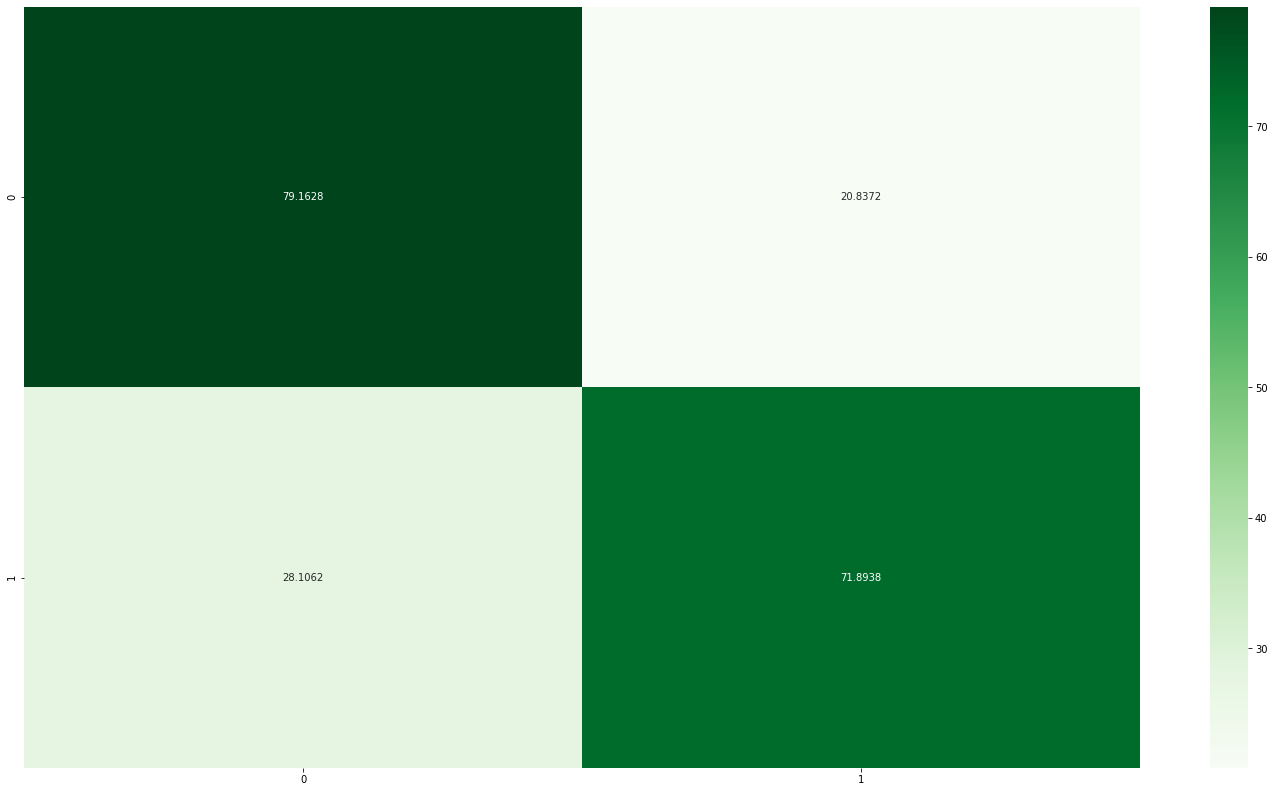

In [183]:
y_svc = test_preds
cm = confusion_matrix(Y_test,y_svc)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
ind = class_indexes
cols = class_indexes
cm_df = pd.DataFrame(norm_cm,cols,ind)                      
plt.figure(figsize=(25,14))  
sns.heatmap(cm_df, annot=True,cmap = "Greens",fmt='g')

print(classification_report(Y_test,y_svc))
print(accuracy_score(Y_test, y_svc))